

# Value-at-Risk (VaR) Model


In [1]:

import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)



In [4]:
# Configuration

tickers = ['VTI', 'QQQ', 'BND', 'GLD']
years = 15
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365*years)

print("Downloading data from yfinance...")
# Downloading data with auto_adjust=False to get both Close and Adj Close
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)
print("Data download complete.")
print("Data columns structure:", data.columns)

# Extracting Adjusted Close prices from the MultiIndex
adj_close = data['Adj Close'].copy()

print(f"Adjusted Close columns: {adj_close.columns.tolist()}")

print(f"Adjusted Close shape: {adj_close.shape}")

# Saving file to CSV
adj_close.to_csv('adjusted_close_prices.csv')
print("✓ Saved Raw Close and Adjusted Close prices to CSV files.")

[*********************100%***********************]  4 of 4 completed


Data download complete.
Data columns structure: MultiIndex([('Adj Close', 'BND'),
            ('Adj Close', 'GLD'),
            ('Adj Close', 'QQQ'),
            ('Adj Close', 'VTI'),
            (    'Close', 'BND'),
            (    'Close', 'GLD'),
            (    'Close', 'QQQ'),
            (    'Close', 'VTI'),
            (     'High', 'BND'),
            (     'High', 'GLD'),
            (     'High', 'QQQ'),
            (     'High', 'VTI'),
            (      'Low', 'BND'),
            (      'Low', 'GLD'),
            (      'Low', 'QQQ'),
            (      'Low', 'VTI'),
            (     'Open', 'BND'),
            (     'Open', 'GLD'),
            (     'Open', 'QQQ'),
            (     'Open', 'VTI'),
            (   'Volume', 'BND'),
            (   'Volume', 'GLD'),
            (   'Volume', 'QQQ'),
            (   'Volume', 'VTI')],
           names=['Price', 'Ticker'])
Adjusted Close columns: ['BND', 'GLD', 'QQQ', 'VTI']
Adjusted Close shape: (3769, 4)
✓ Saved Raw 

In [5]:
print(data)

Price       Adj Close                                          Close  \
Ticker            BND         GLD         QQQ         VTI        BND   
Date                                                                   
2010-09-27  53.684700  126.720001   43.341499   44.811985  82.610001   
2010-09-28  53.801678  127.849998   43.323940   45.065762  82.790001   
2010-09-29  53.743202  127.949997   43.253738   44.988869  82.699997   
2010-09-30  53.717194  127.910004   43.060684   44.888874  82.660004   
2010-10-01  53.673519  128.910004   43.008034   45.088821  82.370003   
...               ...         ...         ...         ...        ...   
2025-09-15  74.709999  338.910004  591.679993  325.890015  74.709999   
2025-09-16  74.720001  339.589996  591.179993  325.450012  74.720001   
2025-09-17  74.589996  336.970001  590.000000  325.160004  74.589996   
2025-09-18  74.400002  335.619995  595.320007  327.209991  74.400002   
2025-09-19  74.430000  339.179993  599.349976  328.440002  74.43

Calculating daily log returns and dropping Nan Values

In [6]:
log_returns = np.log(adj_close/adj_close.shift(1))
log_returns = log_returns.dropna()

print(log_returns)

Ticker           BND       GLD       QQQ       VTI
Date                                              
2010-09-28  0.002177  0.008878 -0.000405  0.005647
2010-09-29 -0.001087  0.000782 -0.001622 -0.001708
2010-09-30 -0.000484 -0.000313 -0.004473 -0.002225
2010-10-01 -0.000813  0.007788 -0.001223  0.004444
2010-10-04  0.002546 -0.003497 -0.010873 -0.008909
...              ...       ...       ...       ...
2025-09-15  0.001876  0.010351  0.008521  0.004860
2025-09-16  0.000134  0.002004 -0.000845 -0.001351
2025-09-17 -0.001741 -0.007745 -0.001998 -0.000891
2025-09-18 -0.002550 -0.004014  0.008977  0.006285
2025-09-19  0.000403  0.010551  0.006747  0.003752

[3768 rows x 4 columns]


Calculating equally weighted portfolio 

In [7]:
portfolio_Value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
print(weights)

[0.25 0.25 0.25 0.25]


Calculating historical portfoilio returns 

In [8]:

historical_returns = (log_returns * weights).sum(axis=1)
print(historical_returns)


Date
2010-09-28    0.004074
2010-09-29   -0.000909
2010-09-30   -0.001874
2010-10-01    0.002549
2010-10-04   -0.005183
                ...   
2025-09-15    0.006402
2025-09-16   -0.000015
2025-09-17   -0.003094
2025-09-18    0.002174
2025-09-19    0.005363
Length: 3768, dtype: float64


Finding X day historical returns 


In [9]:
days = 5 
range_returns = historical_returns.rolling(window=days).sum()
range_returns = range_returns.dropna()
print(range_returns)

Date
2010-10-04   -0.001343
2010-10-05    0.010684
2010-10-06    0.011300
2010-10-07    0.011425
2010-10-08    0.014434
                ...   
2025-09-15    0.013292
2025-09-16    0.013289
2025-09-17    0.008143
2025-09-18    0.006398
2025-09-19    0.010831
Length: 3764, dtype: float64


Specifying confidence level and calculating VAR using historical method 

In [10]:
confidence_level= 0.95
VaR = np.percentile(range_returns, (1 - confidence_level) * 100) * portfolio_Value


print("\n" + "="*50)
print("VALUE-AT-RISK (VaR) RESULTS")
print("="*50)
print(f"Confidence Level: {confidence_level}%")
print(f"{days}-Day VaR (Return): {VaR/portfolio_Value:.4%}")  # Convert back to return
print(f"{days}-Day VaR ($): -${abs(VaR):,.2f}")
print("="*50)



VALUE-AT-RISK (VaR) RESULTS
Confidence Level: 0.95%
5-Day VaR (Return): -2.1164%
5-Day VaR ($): -$21,163.53


Converting to dollar amounts

In [11]:
range_returns_dollar = range_returns * portfolio_Value

# Creating the histogram

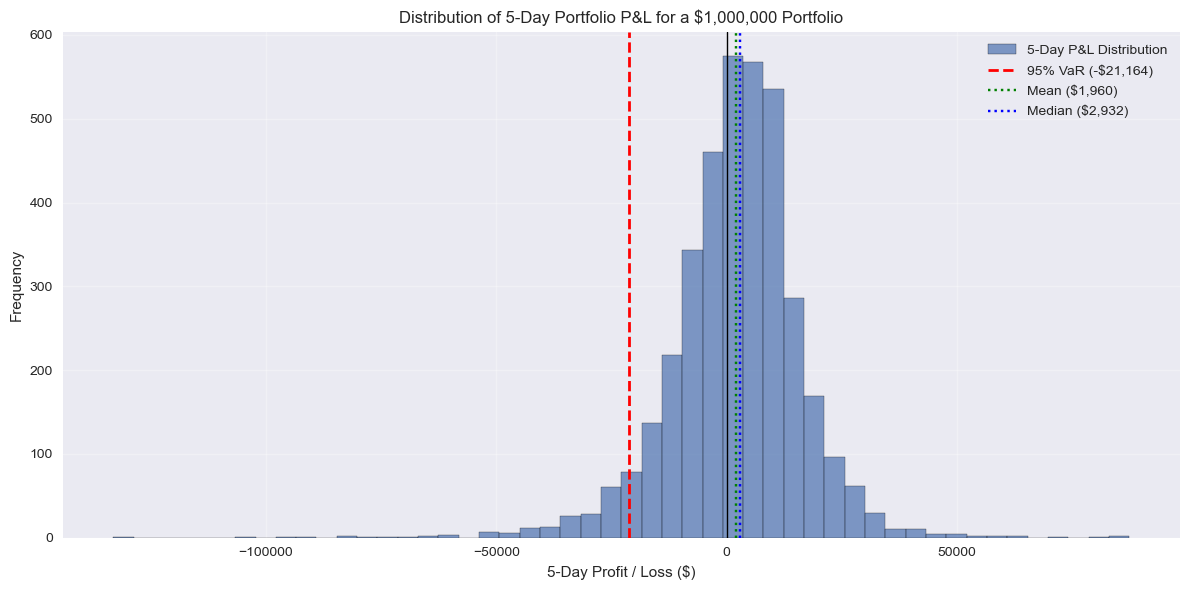


Additional Statistics for 5-Day Returns:
Mean P&L: $1,960.21
Median P&L: $2,931.93
Minimum P&L: $-133,110.01
Maximum P&L: $87,406.82
Number of observations: 3764


In [12]:

plt.figure(figsize=(12, 6))
plt.hist(range_returns_dollar, bins=50, edgecolor='black', alpha=0.7, label=f'{days}-Day P&L Distribution')

# Add VaR line
plt.axvline(VaR, color='red', linestyle='--', linewidth=2, label=f'95% VaR (-${abs(VaR):,.0f})')

# Add zero line
plt.axvline(0, color='black', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel(f'{days}-Day Profit / Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of {days}-Day Portfolio P&L for a ${portfolio_Value:,.0f} Portfolio')
plt.legend()
plt.grid(True, alpha=0.3)

# Adding some statistics to the plot
mean_return = range_returns_dollar.mean()
median_return = range_returns_dollar.median()
plt.axvline(mean_return, color='green', linestyle=':', label=f'Mean (${mean_return:,.0f})')
plt.axvline(median_return, color='blue', linestyle=':', label=f'Median (${median_return:,.0f})')

plt.legend()
plt.tight_layout()
plt.show()

# ADDITIONAL ANALYSIS 
print(f"\nAdditional Statistics for {days}-Day Returns:")
print(f"Mean P&L: ${mean_return:,.2f}")
print(f"Median P&L: ${median_return:,.2f}")
print(f"Minimum P&L: ${range_returns_dollar.min():,.2f}")
print(f"Maximum P&L: ${range_returns_dollar.max():,.2f}")
print(f"Number of observations: {len(range_returns_dollar)}")

## Calculating Parametric VAR 

In [16]:


# 1. Calculate the covariance matrix of the returns
cov_matrix = log_returns.cov()

# 2. Calculate portfolio volatility (standard deviation)
# This formula: sqrt(weights.T * CovarianceMatrix * weights)
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# 3. Define confidence level and get the Z-score (for 95% CI, it's ~1.645)
confidence_level = 0.95
z_score = norm.ppf(1 - confidence_level) # This gives -1.645

# 4. Calculate Parametric VaR
parametric_var = portfolio_volatility * z_score
parametric_var_dollars = parametric_var * portfolio_Value

parametric_var_log_5day = portfolio_volatility * np.sqrt(days) * z_score

print("\n" + "="*60)
print("PARAMETRIC (Variance-Covariance) VaR RESULTS")
print("="*60)
print(f"Portfolio Annualized Volatility: {portfolio_volatility * np.sqrt(252):.2%}")
print(f"1-Day Parametric VaR ({confidence_level:.0%} CI): {parametric_var:.4%}")
print(f"1-Day Parametric VaR ($): -${abs(parametric_var_dollars):,.2f}")
print("="*60)


PARAMETRIC (Variance-Covariance) VaR RESULTS
Portfolio Annualized Volatility: 10.61%
1-Day Parametric VaR (95% CI): -1.0992%
1-Day Parametric VaR ($): -$10,991.87


## Backtesting the VAR Model 

In [47]:

# How many times did the actual loss exceed the predicted VaR?

# Using the historical VaR as our prediction for each day
var_prediction = VaR

# Calculating the actual portfolio P&L for each day
actual_pnl = range_returns * portfolio_Value

# Count the exceptions (days where loss was greater than VaR prediction)
exceptions = actual_pnl < var_prediction
number_of_exceptions = exceptions.sum()
total_days = len(actual_pnl)
exception_rate = number_of_exceptions / total_days

print("\nBACKTEST RESULTS (Historical VaR Model)")
print("----------------------------------------")
print(f"Number of days where loss exceeded VaR: {number_of_exceptions} / {total_days}")
print(f"Exception Rate: {exception_rate:.2%}")
print(f"Expected Exception Rate (for 95% VaR): {1-confidence_level:.2%}")

if abs(exception_rate - (1-confidence_level)) < 0.01:
    print("✅ Model is accurate.")
elif exception_rate > (1-confidence_level):
    print("⚠️ Model UNDERESTIMATES risk (too many exceptions).")
else:
    print("⚠️ Model OVERESTIMATES risk (too few exceptions).")


BACKTEST RESULTS (Historical VaR Model)
----------------------------------------
Number of days where loss exceeded VaR: 189 / 3764
Exception Rate: 5.02%
Expected Exception Rate (for 95% VaR): 5.00%
✅ Model is accurate.
